In [2]:
import sys
COCOAPIROOT = r"D:\学习资料\实验室"
from pycocotools.coco import COCO
from raw_program.data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create a data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test',
                         cocoapi_loc=COCOAPIROOT)

从vocab.pkl文件中加载词汇成功


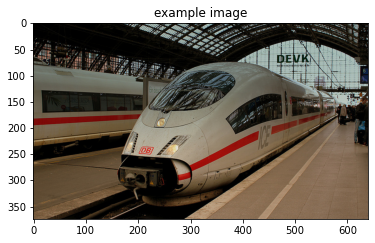

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os
import torch
from raw_program.model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file),  map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file),  map_location='cpu'))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

D:\python\anaconda\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\python\anaconda\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
D:\python\anaconda\envs\PyTorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


DecoderRNN(
  (embedding): Embedding(10321, 512)
  (lstm): LSTM(512, 512, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=512, out_features=10321, bias=True)
  (softmax): Softmax(dim=1)
)

In [6]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output vocab ids:', output)
print('example output tokens:', [data_loader.dataset.vocab.idx2word[x] for x in output])

example output vocab ids: [0, 61, 793, 123, 3, 113, 106, 3, 615, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
example output tokens: ['<start>', 'an', 'image', 'of', 'a', 'man', 'riding', 'a', 'train', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']


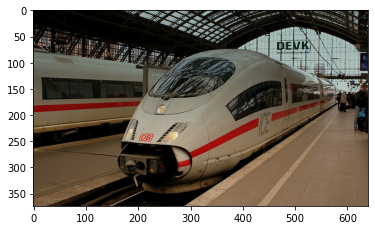

In [7]:
# Show image again
plt.imshow(np.squeeze(orig_image))
plt.show()

In [8]:
# TODO #4: Complete the function.
def clean_sentence(output):
    # Look for key tokens
    # 0 = <start>
    # 1 = <end>
    # 18 = .
    start = 0
    end = len(output)-1
    point = end
    for i in range(len(output)):
        if output[i] == 0:
            start = i+1
            continue
        if output[i] == 18:
            point = i
            continue
        if output[i] == 1:
            end = i
            break
    if point > end:
        point = end
    sentence = " ".join([data_loader.dataset.vocab.idx2word[x] for x in output[start:point]])
    #sentence += "."
    
    return sentence

In [9]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

example sentence: an image of a man riding a train


In [10]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

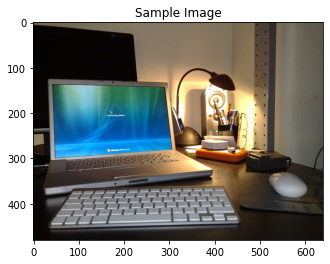

a table with a laptop and a mouse on it


In [28]:
get_prediction()

In [15]:
image.shape

torch.Size([1, 3, 224, 224])

In [35]:
def generator():
    dir_path = input("请输入图片的全局路径：")
    dir_path = dir_path.replace('"', "")
    original_image = Image.open(dir_path)
    plt.imshow(np.squeeze(original_image))
    plt.title('Original Image')
    plt.show()
    image = transform_test(original_image)
    image = image.unsqueeze(1).permute(1, 0, 2, 3)
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output)
    print("The caption is:" + sentence)

请输入图片的全局路径："C:\Users\李宏洋\Desktop\QQ图片20221019192957.jpg"


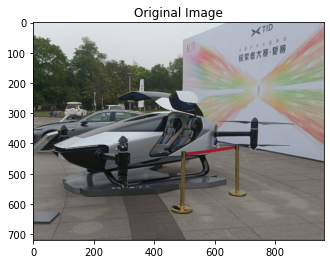

The caption is:a red motorcycle is parked in a garage


In [41]:
generator()